In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

plt.rcParams["font.family"] = "Calibri"


def find_outliers(df, threshold=2):
    # Initialize a boolean mask to keep track of rows to drop
    outlier_rows_mask = np.zeros(len(df), dtype=bool)

    # Iterate over each column
    for col in df.columns:
        # Skip the "t1" and "t2" columns
        if col == "t1" or col == "t2":
            continue

        # Calculate the mean and standard deviation of the column
        mean = df[col].mean()
        std = df[col].std()

        # Find outliers in this column
        outliers = (df[col] - mean).abs() > threshold * std

        # Mark rows with outliers in this column
        outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers)

    # Return the indices of the outliers
    outlier_indices = df[outlier_rows_mask].index
    return outlier_indices


def assign_type(row):
    if row["type"] == "EBF":
        if -23.5 <= row["Lat"] <= 23.5:
            return "tropical_EBF"
        else:
            return "mid_EBF"
    else:
        return row["type"]


def format_mean_se(mean, se):
    # Format the mean and standard error Table
    return f"{mean:.4f} ± {se:.4f}"


# Calculate weighted R2
def weighted_r2_score(y_true, y_pred, weights):
    weighted_mean = np.average(y_true, weights=weights)
    total_sum_squares = np.sum(weights * (y_true - weighted_mean)**2)
    residual_sum_squares = np.sum(weights * (y_true - y_pred)**2)
    return 1 - (residual_sum_squares / total_sum_squares)


# Normalize the standard deviations using z-score normalization
def z_score_normalize(x):
    return (x - np.mean(x)) / np.std(x)

### Load the data and merge the coordinates


In [2]:
df = pd.read_csv("../outputs/data_clean_glass_lai_icos.csv")
df.set_index(pd.to_datetime(df.iloc[:, 0], format="%Y-%m-%d"), inplace=True)
df = df.drop(df.columns[0], axis=1)

ameriflux_coords = pd.read_csv("../data/Ameriflux_coords.csv")
fluxnet_coords = pd.read_csv("../data/Fluxnet_coords.csv")
icos_coords = pd.read_csv("../data/Icos_coords.csv")
icos_coords.drop(["site_name", "ID"], axis=1, inplace=True)
icos_coords.rename({"name": "Name"}, axis=1, inplace=True)
merged_coords = pd.concat([ameriflux_coords, fluxnet_coords, icos_coords],
                          axis=0)
merged_coords.drop_duplicates(subset=merged_coords.columns[0], inplace=True)
merged_coords.reset_index(drop=True, inplace=True)
merged_coords.rename({"Name": "name"}, axis=1, inplace=True)

### Selecting sites

- They should have at least two years of data
- Sort descending based on LUE
- Take the median of the top 10% of the sorted data


In [3]:
names = df["name"].unique()
types = df["type"].unique()

site_annual_max_lue = []
site_annual_max_lue_se = []

for name in names:
    site_df = df[df["name"] == name]
    n_years = len(site_df.index.year.unique())
    if n_years < 2:
        continue
    type = site_df["type"].iloc[0]
    site_df = site_df[[
        "fpar", "nirv", "nirvp", "fesc", "lue", "lai", "glass_lai", "apar"
    ]]
    # Sort based on the "lue" column
    site_df_sorted = site_df.sort_values("lue", ascending=False)

    # Find the 10% threshold
    thresh = np.round(len(site_df_sorted) * 0.1)
    site_df_max = site_df_sorted.iloc[0:int(thresh)]
    annual_max_mean = site_df_max.median()
    annual_max_mean.loc["type"] = type
    annual_max_mean.loc["name"] = name
    annual_max_std = site_df_max.std()
    n = len(site_df_max)
    annual_max_se = annual_max_std / np.sqrt(n)
    annual_max_se.loc["type"] = type
    annual_max_se.loc["name"] = name

    site_annual_max_lue.append(annual_max_mean)
    site_annual_max_lue_se.append(annual_max_se)

site_annual_max_lue = pd.DataFrame(site_annual_max_lue)
site_annual_max_lue_se = pd.DataFrame(site_annual_max_lue_se)
site_annual_max_lue = pd.merge(site_annual_max_lue,
                               merged_coords[["name", "Lat", "Lon"]],
                               on="name",
                               how="left")

### Divide EBF to tropics and temprate


In [4]:
# # Convert the index to a separate column
df.reset_index(inplace=True)

# Rename the new column to 'date'
df.rename(columns={"index": "date"}, inplace=True)
df = pd.merge(df, merged_coords[["name", "Lat", "Lon"]], on="name", how="left")
df.rename(columns={"Unnamed: 0": "date"}, inplace=True)
df["new_type"] = df.apply(assign_type, axis=1)
df["type"] = df["new_type"]

site_annual_max_lue["new_type"] = site_annual_max_lue.apply(assign_type,
                                                            axis=1)
site_annual_max_lue["type"] = site_annual_max_lue["new_type"]

### Drop biomes with less than 3 sites


In [5]:
site_annual_max_lue = site_annual_max_lue.groupby("type").filter(
    lambda x: len(x) >= 3)
types = site_annual_max_lue["type"].unique()
names = site_annual_max_lue["name"].unique()

In [6]:
counts_df = pd.DataFrame(columns=["type", "sites", "days"])

for type in types:
    site_count = len(site_annual_max_lue[site_annual_max_lue["type"] == type])
    days = len(df[df["new_type"] == type])
    counts_df.loc[len(counts_df)] = [type, site_count, days]
print("Total number of sites and days:")
print(counts_df[["sites", "days"]].sum())
print("Number of sites and days for each type:")
counts_df

Total number of sites and days:
sites       320
days     312024
dtype: int64
Number of sites and days for each type:


,type,sites,days
0,DBF,43,43629
1,mid_EBF,8,10898
2,GRA,57,51284
3,CRO,39,40630
4,MF,12,10143
5,WET,34,25751
6,ENF,73,66894
7,OSH,25,25016
8,WSA,9,18751
9,SAV,10,12173


### Map the sites


/tmp/ipykernel_3233220/887405459.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


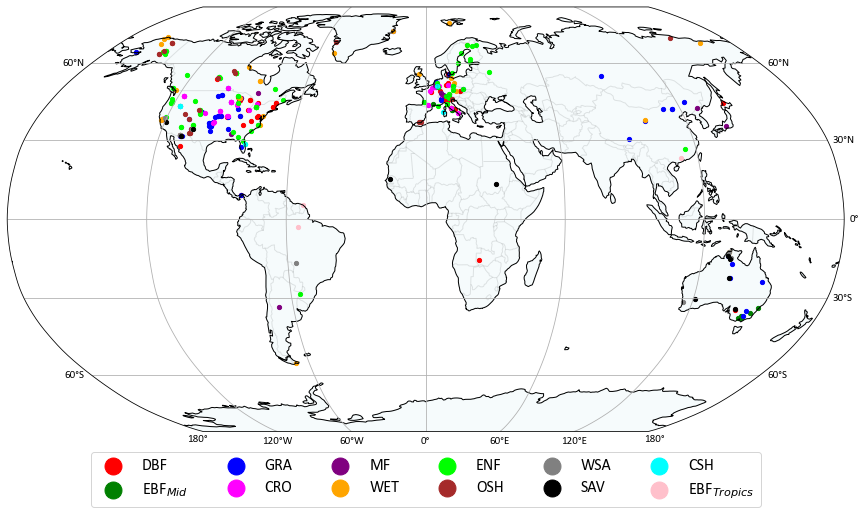

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the world boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Create a GeoDataFrame from your data
gdf = gpd.GeoDataFrame(
    site_annual_max_lue,
    geometry=gpd.points_from_xy(site_annual_max_lue.Lon,
                                site_annual_max_lue.Lat),
)

# Define a dictionary of colors for each site type
colors = [
    "red",
    "green",
    "blue",
    "magenta",
    "purple",
    "orange",
    "lime",
    "brown",
    "gray",
    "black",
    "cyan",
    "pink",
    "yellow",
]
type_color_dict = dict(zip(types, colors))

# Create a larger figure and plot the world
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.add_feature(cfeature.LAND, color="lightblue",
               alpha=0.1)  # add a faint blue color to the land
ax.coastlines()
ax.add_feature(cfeature.BORDERS, alpha=0.1)
gridlines = ax.gridlines(draw_labels=True)
gridlines.top_labels = False
gridlines.left_labels = False

gridlines.xlabel_style = {"size": 11, "color": "black"}
gridlines.ylabel_style = {"size": 11, "color": "black"}

# Plot the sites with different colors based on the type
for site_type in types:
    site_data = gdf[gdf["type"] == site_type]
    label = site_type
    if site_type == "mid_EBF":
        label = "EBF$_{Mid}$"  # Convert 'mid_EBF' to 'EBFMid' with 'Mid' as subscript
    if site_type == "tropical_EBF":
        label = "EBF$_{Tropics}$"
    scatter = ax.scatter(
        site_data["Lon"],
        site_data["Lat"],
        color=type_color_dict[site_type],
        s=18,
        transform=ccrs.PlateCarree(),
        label=label,
    )
# Add a legend at the bottom
legend = ax.legend(bbox_to_anchor=(0.5, -0.03),
                   loc="upper center",
                   ncol=6,
                   fontsize=16,
                   markerscale=4)

# Make the legend fonts bold
# plt.setp(legend.get_texts(), fontweight="bold")

plt.savefig("../outputs/figures/annual_max_lue_map.png",
            dpi=300,
            bbox_inches="tight")

### Group the data by type and calculate the mean and standard error


In [8]:
site_annual_max_lue = site_annual_max_lue[site_annual_max_lue["fesc"] <= 1]
site_annual_max_lue_se = site_annual_max_lue_se[
    site_annual_max_lue_se.index.isin(site_annual_max_lue.index)]
site_annual_max_lue_grouped_mean = (site_annual_max_lue[[
    "fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai", "glass_lai", "apar"
]].groupby("type").median())
site_annual_max_lue_grouped_std = (site_annual_max_lue[[
    "fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai", "glass_lai", "apar"
]].groupby("type").std())
n = site_annual_max_lue.groupby("type").size()
site_annual_max_lue_grouped_se = site_annual_max_lue_grouped_std.div(
    np.sqrt(n), axis=0)
site_annual_max_lue_grouped_mean.to_csv("../outputs/anual_mean_values.csv")
site_annual_max_lue_grouped_se.to_csv("../outputs/anual_se_values.csv")

In [9]:
table = site_annual_max_lue_grouped_mean.copy()
for column in site_annual_max_lue_grouped_mean.columns:
    table[column] = site_annual_max_lue_grouped_mean[column].combine(
        site_annual_max_lue_grouped_se[column], func=format_mean_se)
table.to_csv("../outputs/mean_se_table.csv")
print("Mean and standard error table:")
table

Mean and standard error table:


,fpar,nirv,nirvp,fesc,lue,lai,glass_lai,apar
type,,,,,,,,
CRO,0.6300 ± 0.0161,0.2658 ± 0.0114,108.0225 ± 7.5235,0.4110 ± 0.0099,0.0493 ± 0.0022,1.6625 ± 0.0988,2.2125 ± 0.1478,267.3553 ± 16.4384
CSH,0.3925 ± 0.0893,0.1157 ± 0.0182,38.6992 ± 4.5878,0.2990 ± 0.0155,0.0329 ± 0.0037,0.9000 ± 0.5229,1.3000 ± 0.2469,137.1875 ± 19.4021
DBF,0.8402 ± 0.0244,0.3060 ± 0.0117,72.3497 ± 4.2200,0.3714 ± 0.0103,0.0383 ± 0.0017,4.3281 ± 0.2294,5.2000 ± 0.2391,207.0067 ± 8.9222
ENF,0.6150 ± 0.0170,0.1332 ± 0.0048,26.3184 ± 1.5950,0.2400 ± 0.0058,0.0390 ± 0.0015,1.5625 ± 0.1103,2.1500 ± 0.1278,107.7471 ± 5.7644
GRA,0.5400 ± 0.0245,0.1701 ± 0.0105,42.4951 ± 4.0301,0.3209 ± 0.0077,0.0324 ± 0.0020,1.3250 ± 0.1311,1.5500 ± 0.1319,136.9215 ± 9.6472
MF,0.8000 ± 0.0495,0.2266 ± 0.0191,43.5796 ± 4.7909,0.3051 ± 0.0125,0.0381 ± 0.0024,3.3438 ± 0.3802,4.0813 ± 0.3570,137.7745 ± 11.6688
OSH,0.2629 ± 0.0436,0.0679 ± 0.0123,26.3774 ± 2.2112,0.3051 ± 0.0101,0.0208 ± 0.0024,0.4031 ± 0.1219,0.5000 ± 0.1287,83.2477 ± 8.0863
SAV,0.3271 ± 0.0458,0.0946 ± 0.0164,42.1417 ± 8.0437,0.2683 ± 0.0229,0.0239 ± 0.0026,0.5828 ± 0.1547,0.7781 ± 0.1423,143.7356 ± 21.5652
WET,0.6169 ± 0.0279,0.1718 ± 0.0108,39.7137 ± 4.8739,0.3035 ± 0.0110,0.0293 ± 0.0029,1.5125 ± 0.1590,1.5969 ± 0.2161,132.7478 ± 13.5381


### Plotting the distribution of LUE, NIRv and LAI values for each biome


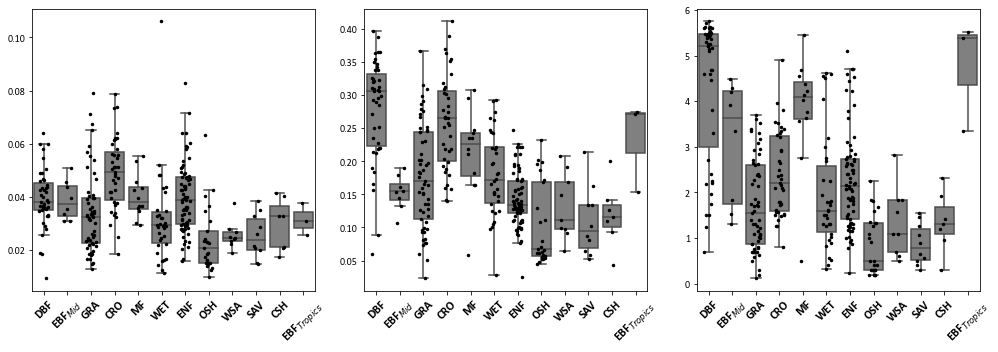

In [10]:
# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))

# Plot the boxplot of "lue" on the first subplot
sns.boxplot(x="type",
            y="lue",
            data=site_annual_max_lue,
            showfliers=False,
            ax=ax1,
            color="gray")
sns.stripplot(
    x="type",
    y="lue",
    data=site_annual_max_lue,
    color="black",
    jitter=0.2,
    size=3.5,
    ax=ax1,
)
ax1.set_ylabel("")
ax1.set_xlabel("")

# Plot the boxplot of "fesc" on the second subplot
sns.boxplot(x="type",
            y="nirv",
            data=site_annual_max_lue,
            showfliers=False,
            ax=ax2,
            color="gray")
sns.stripplot(
    x="type",
    y="nirv",
    data=site_annual_max_lue,
    color="black",
    jitter=0.2,
    size=3.5,
    ax=ax2,
)
ax2.set_ylabel("", fontsize=14, weight="bold")
ax2.set_xlabel("")

# Plot the boxplot of "fesc" on the second subplot
sns.boxplot(
    x="type",
    y="glass_lai",
    data=site_annual_max_lue,
    showfliers=False,
    ax=ax3,
    color="gray",
)
sns.stripplot(
    x="type",
    y="glass_lai",
    data=site_annual_max_lue,
    color="black",
    jitter=0.2,
    size=3.5,
    ax=ax3,
)
ax3.set_ylabel("", fontsize=16, weight="bold")
ax3.set_xlabel("")

for label in ax1.get_xticklabels():
    label.set_weight("bold")
for label in ax2.get_xticklabels():
    label.set_weight("bold")
for label in ax3.get_xticklabels():
    label.set_weight("bold")

for ax in [ax1, ax2, ax3]:
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [
        "EBF$_{Mid}$" if label == "mid_EBF" else label for label in labels
    ]
    labels = [
        "EBF$_{Tropics}$" if label == "tropical_EBF" else label
        for label in labels
    ]
    ax.set_xticklabels(labels)

ax1.tick_params(axis="x", rotation=45, labelsize=12)
ax2.tick_params(axis="x", rotation=45, labelsize=12)
ax3.tick_params(axis="x", rotation=45, labelsize=12)
plt.tight_layout()
plt.savefig("../outputs/figures/annual_max_lue_boxplot.png",
            dpi=300,
            bbox_inches="tight")

### Extract the data for the linear regression and Holling's curve fitting


In [11]:
# Including crop type
types = site_annual_max_lue_grouped_mean.index
lue = site_annual_max_lue_grouped_mean["lue"].values
lue_std = site_annual_max_lue_grouped_std["lue"].values
nirv_std = site_annual_max_lue_grouped_std["nirv"].values
nirv = site_annual_max_lue_grouped_mean["nirv"].values
lai = site_annual_max_lue_grouped_mean["glass_lai"].values
lai_std = site_annual_max_lue_grouped_std["glass_lai"].values
lai = site_annual_max_lue_grouped_mean["lai"].values
lai_std = site_annual_max_lue_grouped_std["lai"].values

Exclude crops from the data


In [12]:
site_annual_max_lue_grouped_mean_no_CRO = site_annual_max_lue_grouped_mean[
    site_annual_max_lue_grouped_mean.index != "CRO"]
site_annual_max_lue_grouped_std_no_CRO = site_annual_max_lue_grouped_std[
    site_annual_max_lue_grouped_std.index != "CRO"]
lue_no_cro = site_annual_max_lue_grouped_mean_no_CRO["lue"].values
lue_std_no_cro = site_annual_max_lue_grouped_std_no_CRO["lue"].values
nirv_no_CRO = site_annual_max_lue_grouped_mean_no_CRO["nirv"].values
nirv_std_no_CRO = site_annual_max_lue_grouped_std_no_CRO["nirv"].values
lai_no_cro = site_annual_max_lue_grouped_mean_no_CRO["glass_lai"].values
lai_std_no_cro = site_annual_max_lue_grouped_std_no_CRO["glass_lai"].values

Get the number of measurements for each type, including crop type and not including crop type, for linear regression. This is needed for the weight calculations


In [13]:
types_no_CRO = site_annual_max_lue_grouped_mean_no_CRO.index
num_measurements = site_annual_max_lue["type"].value_counts()
num_measurements = num_measurements.reindex(types, fill_value=0).values
num_measurements_no_cro = site_annual_max_lue[site_annual_max_lue["type"] !=
                                              "CRO"]["type"].value_counts()
num_measurements_no_cro = num_measurements_no_cro.reindex(types_no_CRO,
                                                          fill_value=0).values

### Fitting the Holling type II curve


In [14]:
import numpy as np
from scipy.optimize import curve_fit
from typing import Tuple, List


def holling_type_II(x: np.ndarray, a: float, h: float) -> np.ndarray:
    return (a * x) / (1 + h * a * x)


def z_score_normalize(x: np.ndarray) -> np.ndarray:
    return (x - np.mean(x)) / np.std(x)


def fit_holling_type_II(
    x: np.ndarray,
    y: np.ndarray,
    x_std: np.ndarray,
    y_std: np.ndarray,
    num_measurements: List[int],
) -> Tuple[float, float, float, float, float, float]:
    """
    Fit the Holling Type II model to the provided data.

    Args:
    x: Independent variable data
    y: Dependent variable data
    x_std: Standard deviation of x
    y_std: Standard deviation of y
    num_measurements: Number of measurements for each data point

    Returns:
    Tuple containing:
    - a_fit: Fitted 'a' parameter
    - h_fit: Fitted 'h' parameter
    - a_error: Standard error of 'a'
    - h_error: Standard error of 'h'
    - bic: Bayesian Information Criterion
    - mae: Mean Absolute Error
    """
    # Normalize standard deviations
    x_std_normalized = z_score_normalize(x_std)
    y_std_normalized = z_score_normalize(y_std)

    # Calculate weights
    weights = np.array(num_measurements) / np.sqrt(
        (x_std_normalized**2 + y_std_normalized**2))
    weights = weights / np.sum(weights)  # Normalize weights to sum to 1

    # Fit the model to the data
    initial_guess = [1, 1]  # Initial guess for parameters a and h
    params, covariance = curve_fit(holling_type_II,
                                   x,
                                   y,
                                   p0=initial_guess,
                                   sigma=1 / np.sqrt(weights))

    # Extract fitted parameters
    a_fit, h_fit = params

    # Calculate the standard errors of the parameters
    param_errors = np.sqrt(np.diag(covariance))
    a_error, h_error = param_errors

    # Calculate predicted values
    y_pred = holling_type_II(x, a_fit, h_fit)

    # Calculate Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y - y_pred))

    # Calculate BIC
    n = len(x)  # number of data points
    k = 2  # number of parameters (a and h)
    residuals = y - y_pred
    sse = np.sum(weights * residuals**2)  # weighted sum of squared errors
    bic = n * np.log(sse / n) + k * np.log(n)

    return a_fit, h_fit, a_error, h_error, bic, mae

### Fitting the linear and Folling model to NIRv and LUE


In [17]:
a_fit_nirv, h_fit_nirv, a_error_nirv, h_error_nirv, bic_nirv, mae_nirv = (
    fit_holling_type_II(x=nirv,
                        y=lue,
                        x_std=nirv_std,
                        y_std=lue_std,
                        num_measurements=num_measurements))

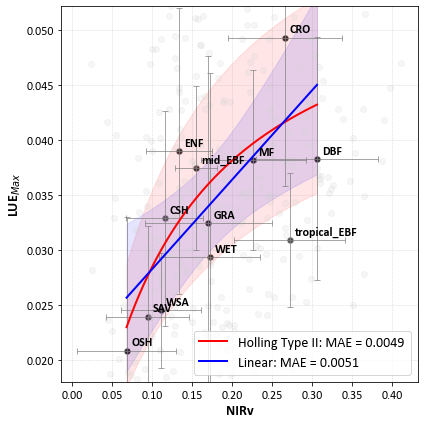

Holling Type II parameters: a = 0.561 ± 0.162, h = 17.332 ± 2.951
BIC (Holling Type II): -151.2568
MAE (Holling Type II): 0.0049
MAE (Linear): 0.0051

Linear Regression Summary:
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.553
Model:                            WLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     12.37
Date:                Tue, 08 Oct 2024   Prob (F-statistic):            0.00557
Time:                        10:33:42   Log-Likelihood:                 42.110
No. Observations:                  12   AIC:                            -80.22
Df Residuals:                      10   BIC:                            -79.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err

/home/hamid/anaconda3/envs/geospatial/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import r2_score
from matplotlib.font_manager import FontProperties


def holling_type_II(x, a, h):
    return (a * x) / (1 + h * a * x)


def calc_ci(x, a, h, a_error, h_error):
    y_lower = holling_type_II(x, a - a_error, h + h_error)
    y_upper = holling_type_II(x, a + a_error, h - h_error)
    return y_lower, y_upper


def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


# Calculate weights using zscore for normalization
nirv_std_normalized = stats.zscore(nirv_std)
lue_std_normalized = stats.zscore(lue_std)
weights = num_measurements / np.sqrt(
    (nirv_std_normalized**2 + lue_std_normalized**2))
weights = weights / np.sum(weights)

# Linear regression
X = sm.add_constant(nirv)
wls_model = sm.WLS(lue, X, weights=weights)
results = wls_model.fit()

# Calculate overall p-value for linear model
f_statistic = results.fvalue
df_num = results.df_model
df_denom = results.df_resid
overall_p_value = stats.f.sf(f_statistic, df_num, df_denom)

# Holling Type II model
y_pred_holling = holling_type_II(nirv, a_fit_nirv, h_fit_nirv)

# Calculate MAE for both models
mae_linear = mean_absolute_error(lue, results.predict(X))
mae_holling = mae_nirv  # Use the MAE from the fit_holling_type_II function

# Set up font
font = FontProperties()
font.set_weight("bold")
font.set_size(14)

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot data points
ax.errorbar(
    nirv,
    lue,
    xerr=nirv_std,
    yerr=lue_std,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)
ax.scatter(nirv, lue, color="black", alpha=0.8, edgecolor="white", s=50)

# Generate points for the fitted curves
x_fit = np.linspace(min(nirv), max(nirv), 1000)
y_fit_holling = holling_type_II(x_fit, a_fit_nirv, h_fit_nirv)

# Calculate confidence intervals for Holling Type II
y_fit_lower, y_fit_upper = calc_ci(x_fit, a_fit_nirv, h_fit_nirv, a_error_nirv,
                                   h_error_nirv)

# Plot Holling Type II fitted curve and confidence intervals
ax.fill_between(x_fit, y_fit_lower, y_fit_upper, color="red", alpha=0.1)
ax.plot(
    x_fit,
    y_fit_holling,
    "r-",
    linewidth=2,
    label=f"Holling Type II: MAE = {mae_holling:.4f}",
)

# Generate predictions for linear model
y_fit_linear = results.predict(sm.add_constant(x_fit))

# Calculate confidence intervals for linear model
y_fit_linear_ci = results.get_prediction(sm.add_constant(x_fit)).conf_int()

# Plot linear fitted curve and confidence intervals
ax.fill_between(
    x_fit,
    y_fit_linear_ci[:, 0],
    y_fit_linear_ci[:, 1],
    color="blue",
    alpha=0.1,
)
ax.plot(x_fit,
        y_fit_linear,
        "b-",
        linewidth=2,
        label=f"Linear: MAE = {mae_linear:.4f}")

# Plot background scatter
ax.scatter(
    site_annual_max_lue["nirv"],
    site_annual_max_lue["lue"],
    alpha=0.2,
    color="lightgray",
)

# Add labels for each point
for i, txt in enumerate(types):
    ax.annotate(
        txt,
        (nirv[i], lue[i]),
        fontsize=12,
        weight="bold",
        xytext=(5, 5),
        textcoords="offset points",
    )

# Enhance plot style
ax.set_xlabel("NIRv", fontproperties=font)
ax.set_ylabel(r"LUE$_{Max}$", fontproperties=font)
ax.legend(fontsize=14)
ax.grid(True,
        which="both",
        linestyle="--",
        linewidth=0.5,
        color="gray",
        alpha=0.3)
ax.tick_params(axis="both", which="major", labelsize=12)

# Set y-axis limits
ymin = max(0,
           min(lue) - 0.1 * (max(lue) - min(lue)))  # Ensure non-negative LUE
ymax = min(max(lue) + 0.1 * (max(lue) - min(lue)),
           1)  # Cap at 1 for reasonable scale
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.savefig(
    "../outputs/figures/NIRV_vs_LUE_Linear_and_Holling_Comparison.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Print results
print(
    f"Holling Type II parameters: a = {a_fit_nirv:.3f} ± {a_error_nirv:.3f}, h = {h_fit_nirv:.3f} ± {h_error_nirv:.3f}"
)
print(f"BIC (Holling Type II): {bic_nirv:.4f}")
print(f"MAE (Holling Type II): {mae_holling:.4f}")
print(f"MAE (Linear): {mae_linear:.4f}")
print("\nLinear Regression Summary:")
print(results.summary())
print(f"\nOverall model p-value: {overall_p_value:.4f}")

### Fitting Holling model to LAI and LUE with and without crops


In [18]:
a_fit_cro, h_fit_cro, a_error_cro, h_error_cro, bic_cro, mae_cro = fit_holling_type_II(
    x=lai,
    y=lue,
    x_std=lai_std,
    y_std=lue_std,
    num_measurements=num_measurements)
a_fit_no_cro, h_fit_no_cro, a_error_no_cro, h_error_no_cro, bic_no_cro, mae_no_cro = (
    fit_holling_type_II(
        x=lai_no_cro,
        y=lue_no_cro,
        x_std=lai_std_no_cro,
        y_std=lue_std_no_cro,
        num_measurements=num_measurements_no_cro,
    ))

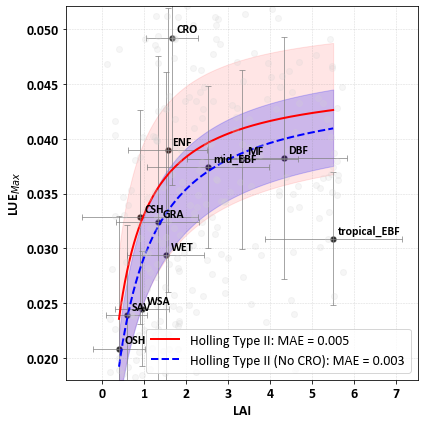

Fitted parameters (All): a = 0.121 ± 0.055, h = 21.952 ± 2.477
BIC (All): -151.4768
MAE (All): 0.0050
Fitted parameters (excluding CRO): a = 0.083 ± 0.020, h = 22.225 ± 1.521
BIC (excluding CRO): -150.8165
MAE (excluding CRO): 0.0031


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


def holling_type_II(x, a, h):
    return (a * x) / (1 + h * a * x)


def calc_ci(x, a, h, a_error, h_error):
    y_lower = holling_type_II(x, a - a_error, h + h_error)
    y_upper = holling_type_II(x, a + a_error, h - h_error)
    return y_lower, y_upper


def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


# Calculate MAE for both models
mae_all = mean_absolute_error(lue, holling_type_II(lai, a_fit_cro, h_fit_cro))
mae_no_cro = mean_absolute_error(
    lue_no_cro, holling_type_II(lai_no_cro, a_fit_no_cro, h_fit_no_cro))

# Set up font
font = FontProperties()
font.set_weight("bold")
font.set_size(14)

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot data points
ax.errorbar(
    lai,
    lue,
    xerr=lai_std,
    yerr=lue_std,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)
ax.scatter(lai, lue, color="black", alpha=0.8, edgecolor="white", s=50)

# Generate points for the fitted curves
x_fit = np.linspace(min(lai), max(lai), 1000)
y_fit = holling_type_II(x_fit, a_fit_cro, h_fit_cro)
y_fit_no_CRO = holling_type_II(x_fit, a_fit_no_cro, h_fit_no_cro)

# Calculate confidence intervals
y_fit_lower, y_fit_upper = calc_ci(x_fit, a_fit_cro, h_fit_cro, a_error_cro,
                                   h_error_cro)
y_fit_no_CRO_lower, y_fit_no_CRO_upper = calc_ci(x_fit, a_fit_no_cro,
                                                 h_fit_no_cro, a_error_no_cro,
                                                 h_error_no_cro)

# Plot fitted curves and confidence intervals
ax.fill_between(x_fit, y_fit_lower, y_fit_upper, color="red", alpha=0.1)
ax.fill_between(
    x_fit,
    y_fit_no_CRO_lower,
    y_fit_no_CRO_upper,
    color="blue",
    alpha=0.2,
)
ax.plot(x_fit,
        y_fit,
        "r-",
        linewidth=2,
        label=f"Holling Type II: MAE = {mae_all:.3f}")
ax.plot(
    x_fit,
    y_fit_no_CRO,
    "b--",
    linewidth=2,
    label=f"Holling Type II (No CRO): MAE = {mae_no_cro:.3f}",
)
background_scatter = ax.plot(
    site_annual_max_lue["glass_lai"],
    site_annual_max_lue["lue"],
    "o",
    alpha=0.2,
    color="lightgray",
)
# Add labels for each point
for i, txt in enumerate(types):
    ax.annotate(
        txt,
        (lai[i], lue[i]),
        fontsize=12,
        weight="bold",
        xytext=(5, 5),
        textcoords="offset points",
    )

# Enhance plot style
ax.grid(True,
        which="both",
        linestyle="--",
        linewidth=0.5,
        color="gray",
        alpha=0.3)
ax.legend(fontsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font)

# Set axis labels
ax.set_xlabel("LAI", fontproperties=font)
ax.set_ylabel(r"LUE$_{Max}$", fontproperties=font)

# Set y-axis limits
ymin = max(0,
           min(lue) - 0.1 * (max(lue) - min(lue)))  # Ensure non-negative LUE
ymax = min(max(lue) + 0.1 * (max(lue) - min(lue)),
           1)  # Cap at 1 for reasonable scale
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.savefig(
    "../outputs/figures/Holling_Type_II_Comparison_Plot_with_CI_MAE.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Print results
print(
    f"Fitted parameters (All): a = {a_fit_cro:.3f} ± {a_error_cro:.3f}, h = {h_fit_cro:.3f} ± {h_error_cro:.3f}"
)
print(f"BIC (All): {bic_cro:.4f}")
print(f"MAE (All): {mae_all:.4f}")
print(
    f"Fitted parameters (excluding CRO): a = {a_fit_no_cro:.3f} ± {a_error_no_cro:.3f}, h = {h_fit_no_cro:.3f} ± {h_error_no_cro:.3f}"
)
print(f"BIC (excluding CRO): {bic_no_cro:.4f}")
print(f"MAE (excluding CRO): {mae_no_cro:.4f}")


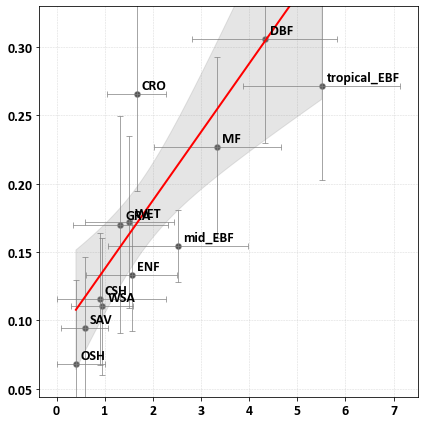


Fitted Equation:
NIRV = 0.0876 +0.0501 * LAI

Fitted parameters:
Parameter 0: 0.0876 ± 0.0236
Parameter 1: 0.0501 ± 0.0117

Confidence Intervals:
[[0.0351306  0.14011282]
 [0.02399895 0.07612654]]

P-values for coefficients:
Intercept: 0.0040
LAI: 0.0016

Model Summary:
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.647
Model:                            WLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     18.32
Date:                Tue, 08 Oct 2024   Prob (F-statistic):            0.00161
Time:                        10:34:29   Log-Likelihood:                 19.150
No. Observations:                  12   AIC:                            -34.30
Df Residuals:                      10   BIC:                            -33.33
Df Model:                           1                                         
Covariance Type: 

/home/hamid/anaconda3/envs/geospatial/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [21]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from matplotlib.font_manager import FontProperties


# Define a flexible polynomial function
def flexible_polynomial(x, *params):
    return np.polynomial.polynomial.polyval(x, params)


# Function to format the equation
def format_equation(params):
    terms = []
    for i, p in enumerate(params):
        if i == 0:
            terms.append(f"{p:.4f}")
        elif i == 1:
            terms.append(f"{p:+.4f} * LAI")
        else:
            terms.append(f"{p:+.4f} * LAI^{i}")
    return "NIRV = " + " ".join(terms)


font = FontProperties()
font.set_weight("bold")
font.set_size(14)

# Calculate weights
# Normalize LAI and NIRV standard deviations
lai_std_normalized = stats.zscore(lai_std)
nirv_std_normalized = stats.zscore(nirv_std)

# Calculate weights using normalized standard deviations
weights = num_measurements / np.sqrt(
    (lai_std_normalized**2 + nirv_std_normalized**2))

# Normalize weights to sum to 1
weights = weights / np.sum(weights)

# Perform weighted polynomial regression
degree = 1  # You can adjust this to change the flexibility of the model
X = sm.add_constant(np.column_stack([lai**i for i in range(1, degree + 1)]))
wls_model = sm.WLS(nirv, X, weights=weights)
results = wls_model.fit()

# Generate predictions for plotting
lai_pred = np.linspace(np.min(lai), np.max(lai), 1000)
X_pred = sm.add_constant(
    np.column_stack([lai_pred**i for i in range(1, degree + 1)]))
nirv_pred = results.predict(X_pred)

# Calculate confidence intervals
conf_int = results.conf_int(alpha=0.05)

# Calculate prediction intervals
pred_interval = results.get_prediction(X_pred).conf_int(alpha=0.05)

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Add the background scatter plot
background_scatter = ax.plot(
    lai,
    nirv,
    "o",
    alpha=0.2,
    color="lightgray",
)

# Add error bars
(_, caps, _) = ax.errorbar(
    x=lai,
    y=nirv,
    xerr=[np.minimum(lai, lai_std), lai_std],
    yerr=nirv_std,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)

# Add black bullets for data points
ax.scatter(lai,
           nirv,
           color="black",
           alpha=0.8,
           edgecolor="white",
           s=50,
           label="Data")

# Plot fitted curve
ax.plot(lai_pred, nirv_pred, "r-", linewidth=2, label="Fitted Curve")

# Add prediction interval
ax.fill_between(
    lai_pred,
    pred_interval[:, 0],
    pred_interval[:, 1],
    color="gray",
    alpha=0.2,
    label="95% Prediction Interval",
)

# Add labels for each point
for i, txt in enumerate(types):
    ax.annotate(
        txt,
        (lai[i], nirv[i]),
        fontsize=14,
        weight="bold",
        xytext=(5, 5),
        textcoords="offset points",
    )

# Enhance plot style
ax.grid(True,
        which="both",
        linestyle="--",
        linewidth=0.5,
        color="gray",
        alpha=0.3)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font)

# Set y-axis limits
main_data_ymin = min(nirv) - 0.1 * (max(nirv) - min(nirv))
main_data_ymax = max(nirv) + 0.1 * (max(nirv) - min(nirv))
background_ymin = np.percentile(nirv, 1)
background_ymax = np.percentile(nirv, 97.5)

ymin = max(min(main_data_ymin, background_ymin), 0)  # Ensure non-negative NIRV
ymax = min(max(main_data_ymax, background_ymax),
           1)  # Cap at 1 for reasonable scale

ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.savefig("../outputs/figures/LAI_vs_NIRV_plot.png",
            dpi=300,
            bbox_inches="tight")
plt.show()

# Print the equation
print("\nFitted Equation:")
print(format_equation(results.params))

# Print results
print("\nFitted parameters:")
for i, param in enumerate(results.params):
    print(f"Parameter {i}: {param:.4f} ± {results.bse[i]:.4f}")

print("\nConfidence Intervals:")
print(conf_int)
print("\nP-values for coefficients:")
for i, p_value in enumerate(results.pvalues):
    if i == 0:
        print(f"Intercept: {p_value:.4f}")
    elif i == 1:
        print(f"LAI: {p_value:.4f}")
    else:
        print(f"LAI^{i}: {p_value:.4f}")
print("\nModel Summary:")
print(results.summary())
print(f"\nAIC: {results.aic:.4f}")
print(f"BIC: {results.bic:.4f}")

# Calculate R-squared
r_squared = r2_score(nirv, results.predict(X))
print(f"\nR-squared: {r_squared:.4f}")
print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")

# Calculate overall p-value
f_statistic = results.fvalue
df_num = results.df_model
df_denom = results.df_resid
overall_p_value = stats.f.sf(f_statistic, df_num, df_denom)
print(f"\nOverall model p-value: {overall_p_value:.4f}")